Creation of some of the plots that were used in the thesis document (other plots are scattered throughout other files).

In [1]:
%matplotlib inline

import datetime
import math

import matplotlib.ticker
import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.patches as patches
import numpy as np
from matplotlib import cm
import seaborn as sns
sns.set(style="ticks")
import scipy

import datasets
import sax

In [510]:
ds = datasets.load('2014')

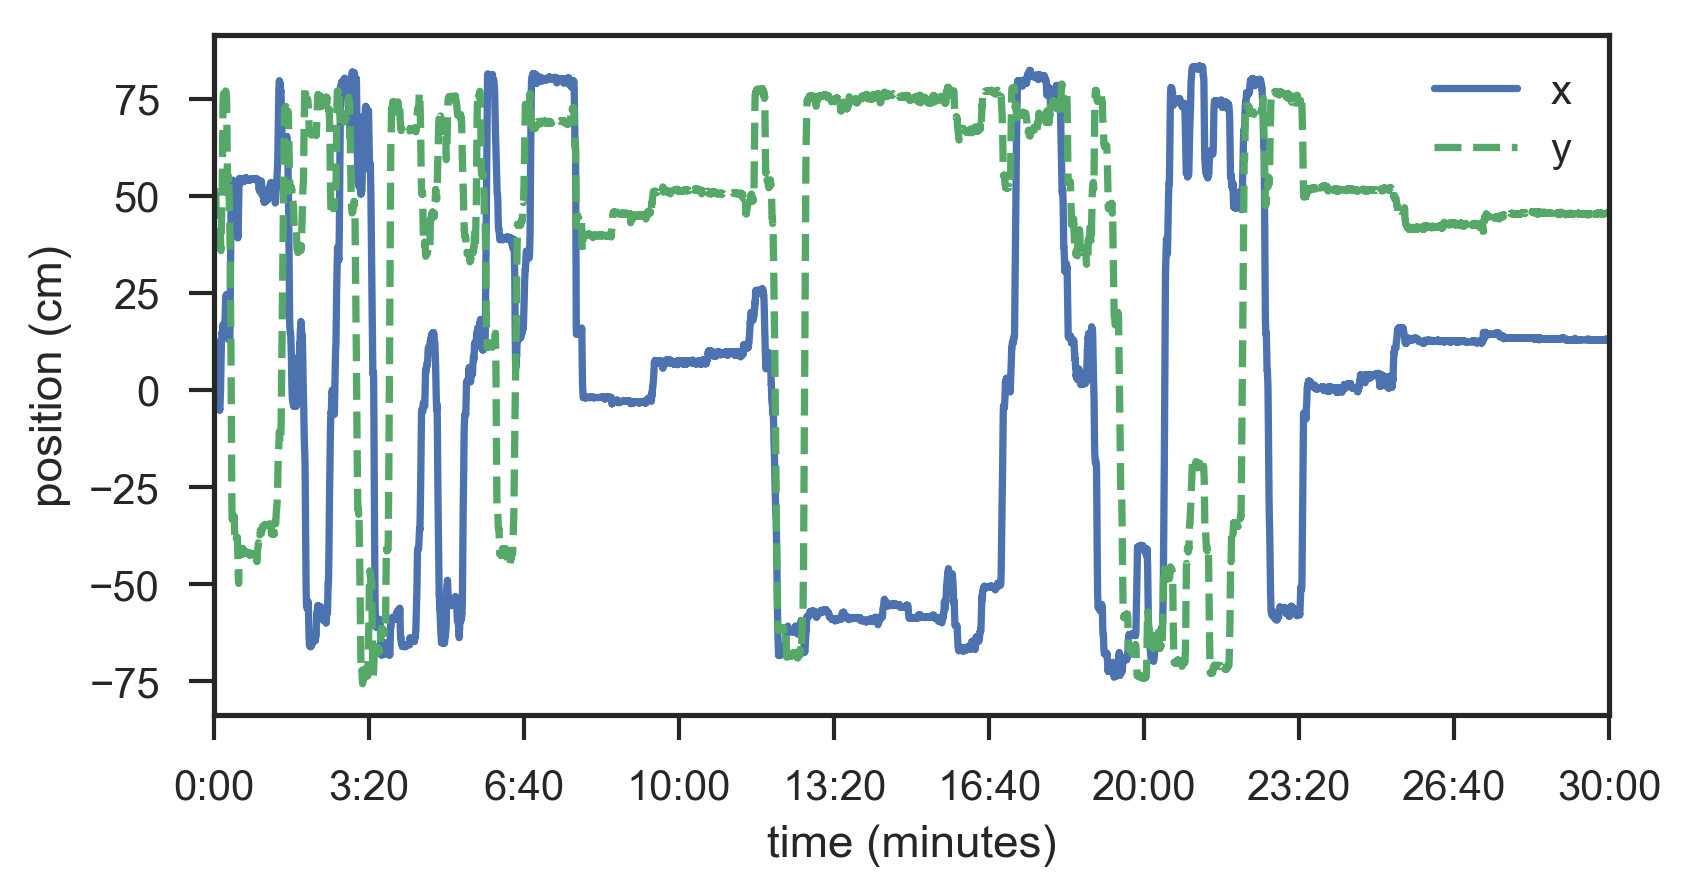

In [519]:
ax = plt.figure(figsize=(6,3),dpi=300).add_subplot(111)
data = ds.isel(rat=0,session=3)[['x','y']].to_array().T.to_pandas()
data.columns = ['x','y']
data.x.plot(ax=ax,linestyle='-')
data.y.plot(ax=ax,linestyle='--')
ax.legend()
labels = ax.get_xticks().tolist()
def timestr(val):
    rem, mins = math.modf(val/1000000000/60)
    secs = round(rem*60)
    return f'{int(mins)}:{secs:02d}'
labels = [timestr(label) for label in labels]
ax.set_xticklabels(labels)
ax.set_xlabel('time (minutes)')
ax.set_ylabel('position (cm)')

In [8]:
ds.isel(rat=0,session=3)

<xarray.Dataset>
Dimensions:      (time: 45000)
Coordinates:
    rat          <U3 '110'
    session      <U10 'injection3'
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    object 's'
    trial        object '29'
Data variables:
    area         (time) float64 87.68 88.79 88.45 88.19 143.8 89.05 90.08 ...
    areachange   (time) float64 13.14 9.532 4.981 2.834 232.0 232.9 1.717 ...
    direction    (time) float64 81.94 82.37 114.6 90.92 179.0 82.37 82.37 ...
    elongation   (time) float64 0.7838 0.7785 0.7867 0.7849 0.9562 0.7745 ...
    time_offset  float64 8.52
    x            (time) float64 16.65 15.08 13.54 12.21 35.87 18.07 16.94 ...
    y            (time) float64 38.77 38.84 38.75 38.6 57.48 44.27 43.7 ...
Attributes:
    dataset:   2014
    objects:   [[ 46.5 -42.5]\n [  4.5  44. ]\n [-69.  -69. ]\n [-66.5  73.5]]
    boundary:  [[-61.5    78.   ]\n [-30.     80.125]\n [  0.     80.75 ]\n [...

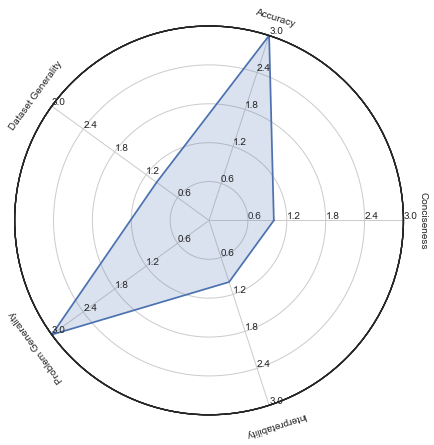

In [478]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics


def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    # for d, (y1, y2) in zip(data[1:], ranges[1:]):
    for d, (y1, y2) in zip(data, ranges):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)

    x1, x2 = ranges[0]
    d = data[0]

    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1

    sdata = [d]

    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1

        sdata.append((d-y1) / (y2-y1) * (x2 - x1) + x1)

    return sdata

def set_rgrids(self, radii, labels=None, angle=None, fmt=None,
               **kwargs):
    """
    Set the radial locations and labels of the *r* grids.
    The labels will appear at radial distances *radii* at the
    given *angle* in degrees.
    *labels*, if not None, is a ``len(radii)`` list of strings of the
    labels to use at each radius.
    If *labels* is None, the built-in formatter will be used.
    Return value is a list of tuples (*line*, *label*), where
    *line* is :class:`~matplotlib.lines.Line2D` instances and the
    *label* is :class:`~matplotlib.text.Text` instances.
    kwargs are optional text properties for the labels:
    %(Text)s
    ACCEPTS: sequence of floats
    """
    # Make sure we take into account unitized data
    radii = self.convert_xunits(radii)
    radii = np.asarray(radii)
    rmin = radii.min()
    # if rmin <= 0:
    #     raise ValueError('radial grids must be strictly positive')

    self.set_yticks(radii)
    if labels is not None:
        self.set_yticklabels(labels)
    elif fmt is not None:
        self.yaxis.set_major_formatter(FormatStrFormatter(fmt))
    if angle is None:
        angle = self.get_rlabel_position()
    self.set_rlabel_position(angle)
    for t in self.yaxis.get_ticklabels():
        t.update(kwargs)
    return self.yaxis.get_gridlines(), self.yaxis.get_ticklabels()

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            # ax.set_rgrids(grid, labels=gridlabel, angle=angles[i])
            set_rgrids(ax, grid, labels=gridlabel, angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

# example data
variables = ("Conciseness", "Accuracy", "Dataset Generality", "Problem Generality", "Interpretability")
data = (1,3,1,3,1)
ranges = [(0,3)] * len(variables)            
# plotting
fig1 = plt.figure(figsize=(6, 6))
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data)
radar.fill(data, alpha=0.2)
plt.show()    


In [498]:
import importlib
importlib.reload(radar)

<module 'radar' from '/home/marein/ai-bachelor-thesis/scripts/radar.py'>

In [499]:
import radar

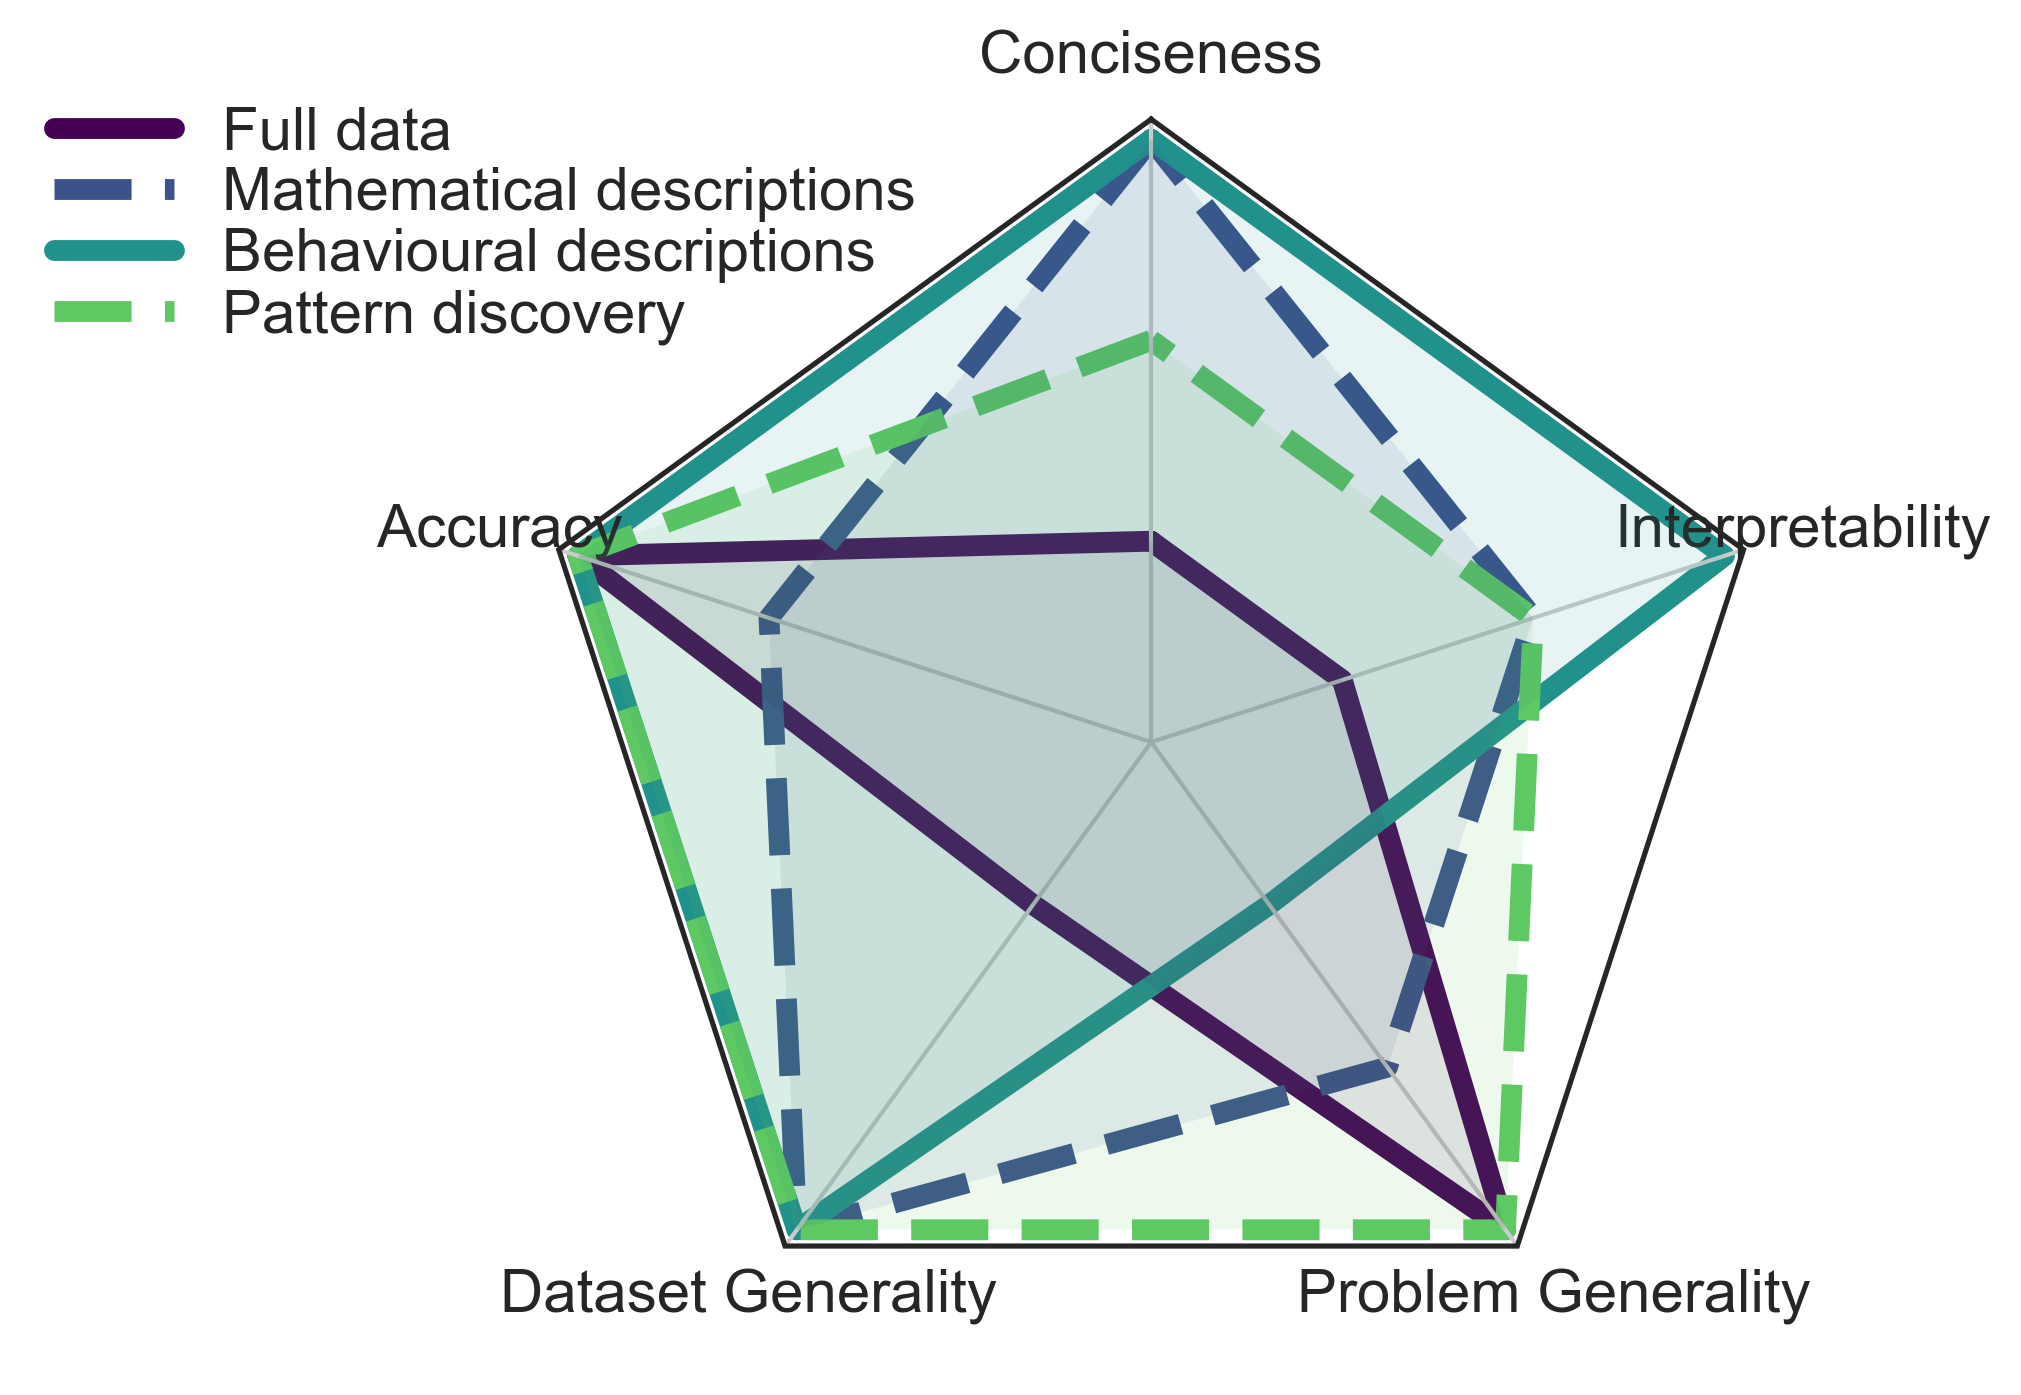

In [500]:
from radar import radar_graph

labels = ["Conciseness", "Accuracy", "Dataset Generality", "Problem Generality", "Interpretability"]
names = ['Full data', 'Mathematical descriptions', 'Behavioural descriptions', 'Pattern discovery']
colors = [scalarMap.to_rgba(i) for i in range(6)]
full = [1,3,1,3,1]
math = [3,2,3,2,2]
beha = [3,3,3,1,3]
patt = [2,3,3,3,2]

radar_graph(labels, names, colors, full, math, beha, patt)

In [493]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
jet = cm = plt.cm.get_cmap('viridis', 5)
cNorm  = colors.Normalize(vmin=0, vmax=5)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

In [92]:
scalarMap.to_rgba()

(0.26700400000000002, 0.0048739999999999999, 0.32941500000000001, 1.0)

In [93]:
jet.colors[0]

[0.267004, 0.004874, 0.329415]

In [145]:
ds

<xarray.Dataset>
Dimensions:      (rat: 8, session: 10, time: 45000)
Coordinates:
  * rat          (rat) object '110' '112' '114' '109' '111' '113' '115' '117'
  * session      (session) object 'injection1' 'injection2' 'injection3' ...
  * time         (time) timedelta64[ns] 00:00:00 00:00:00.040000 ...
    treatment    (rat) object 's' 's' 's' 'q' 'q' 'q' 'q' 'q'
    trial        (rat, session) object '5' '17' '29' '41' '53' '65' '77' ...
Data variables:
    area         (rat, session, time) float64 58.74 58.31 51.87 51.18 51.18 ...
    areachange   (rat, session, time) float64 14.86 13.48 12.28 11.85 12.71 ...
    direction    (rat, session, time) float64 147.6 137.3 135.0 129.3 130.0 ...
    elongation   (rat, session, time) float64 0.7867 0.7429 0.7395 0.7292 ...
    time_offset  (rat, session) float64 8.04 5.04 8.52 7.2 6.6 9.12 8.76 ...
    x            (rat, session, time) float64 -3.408 -3.288 -3.142 -2.898 ...
    y            (rat, session, time) float64 2.523 2.725 2.976 3.

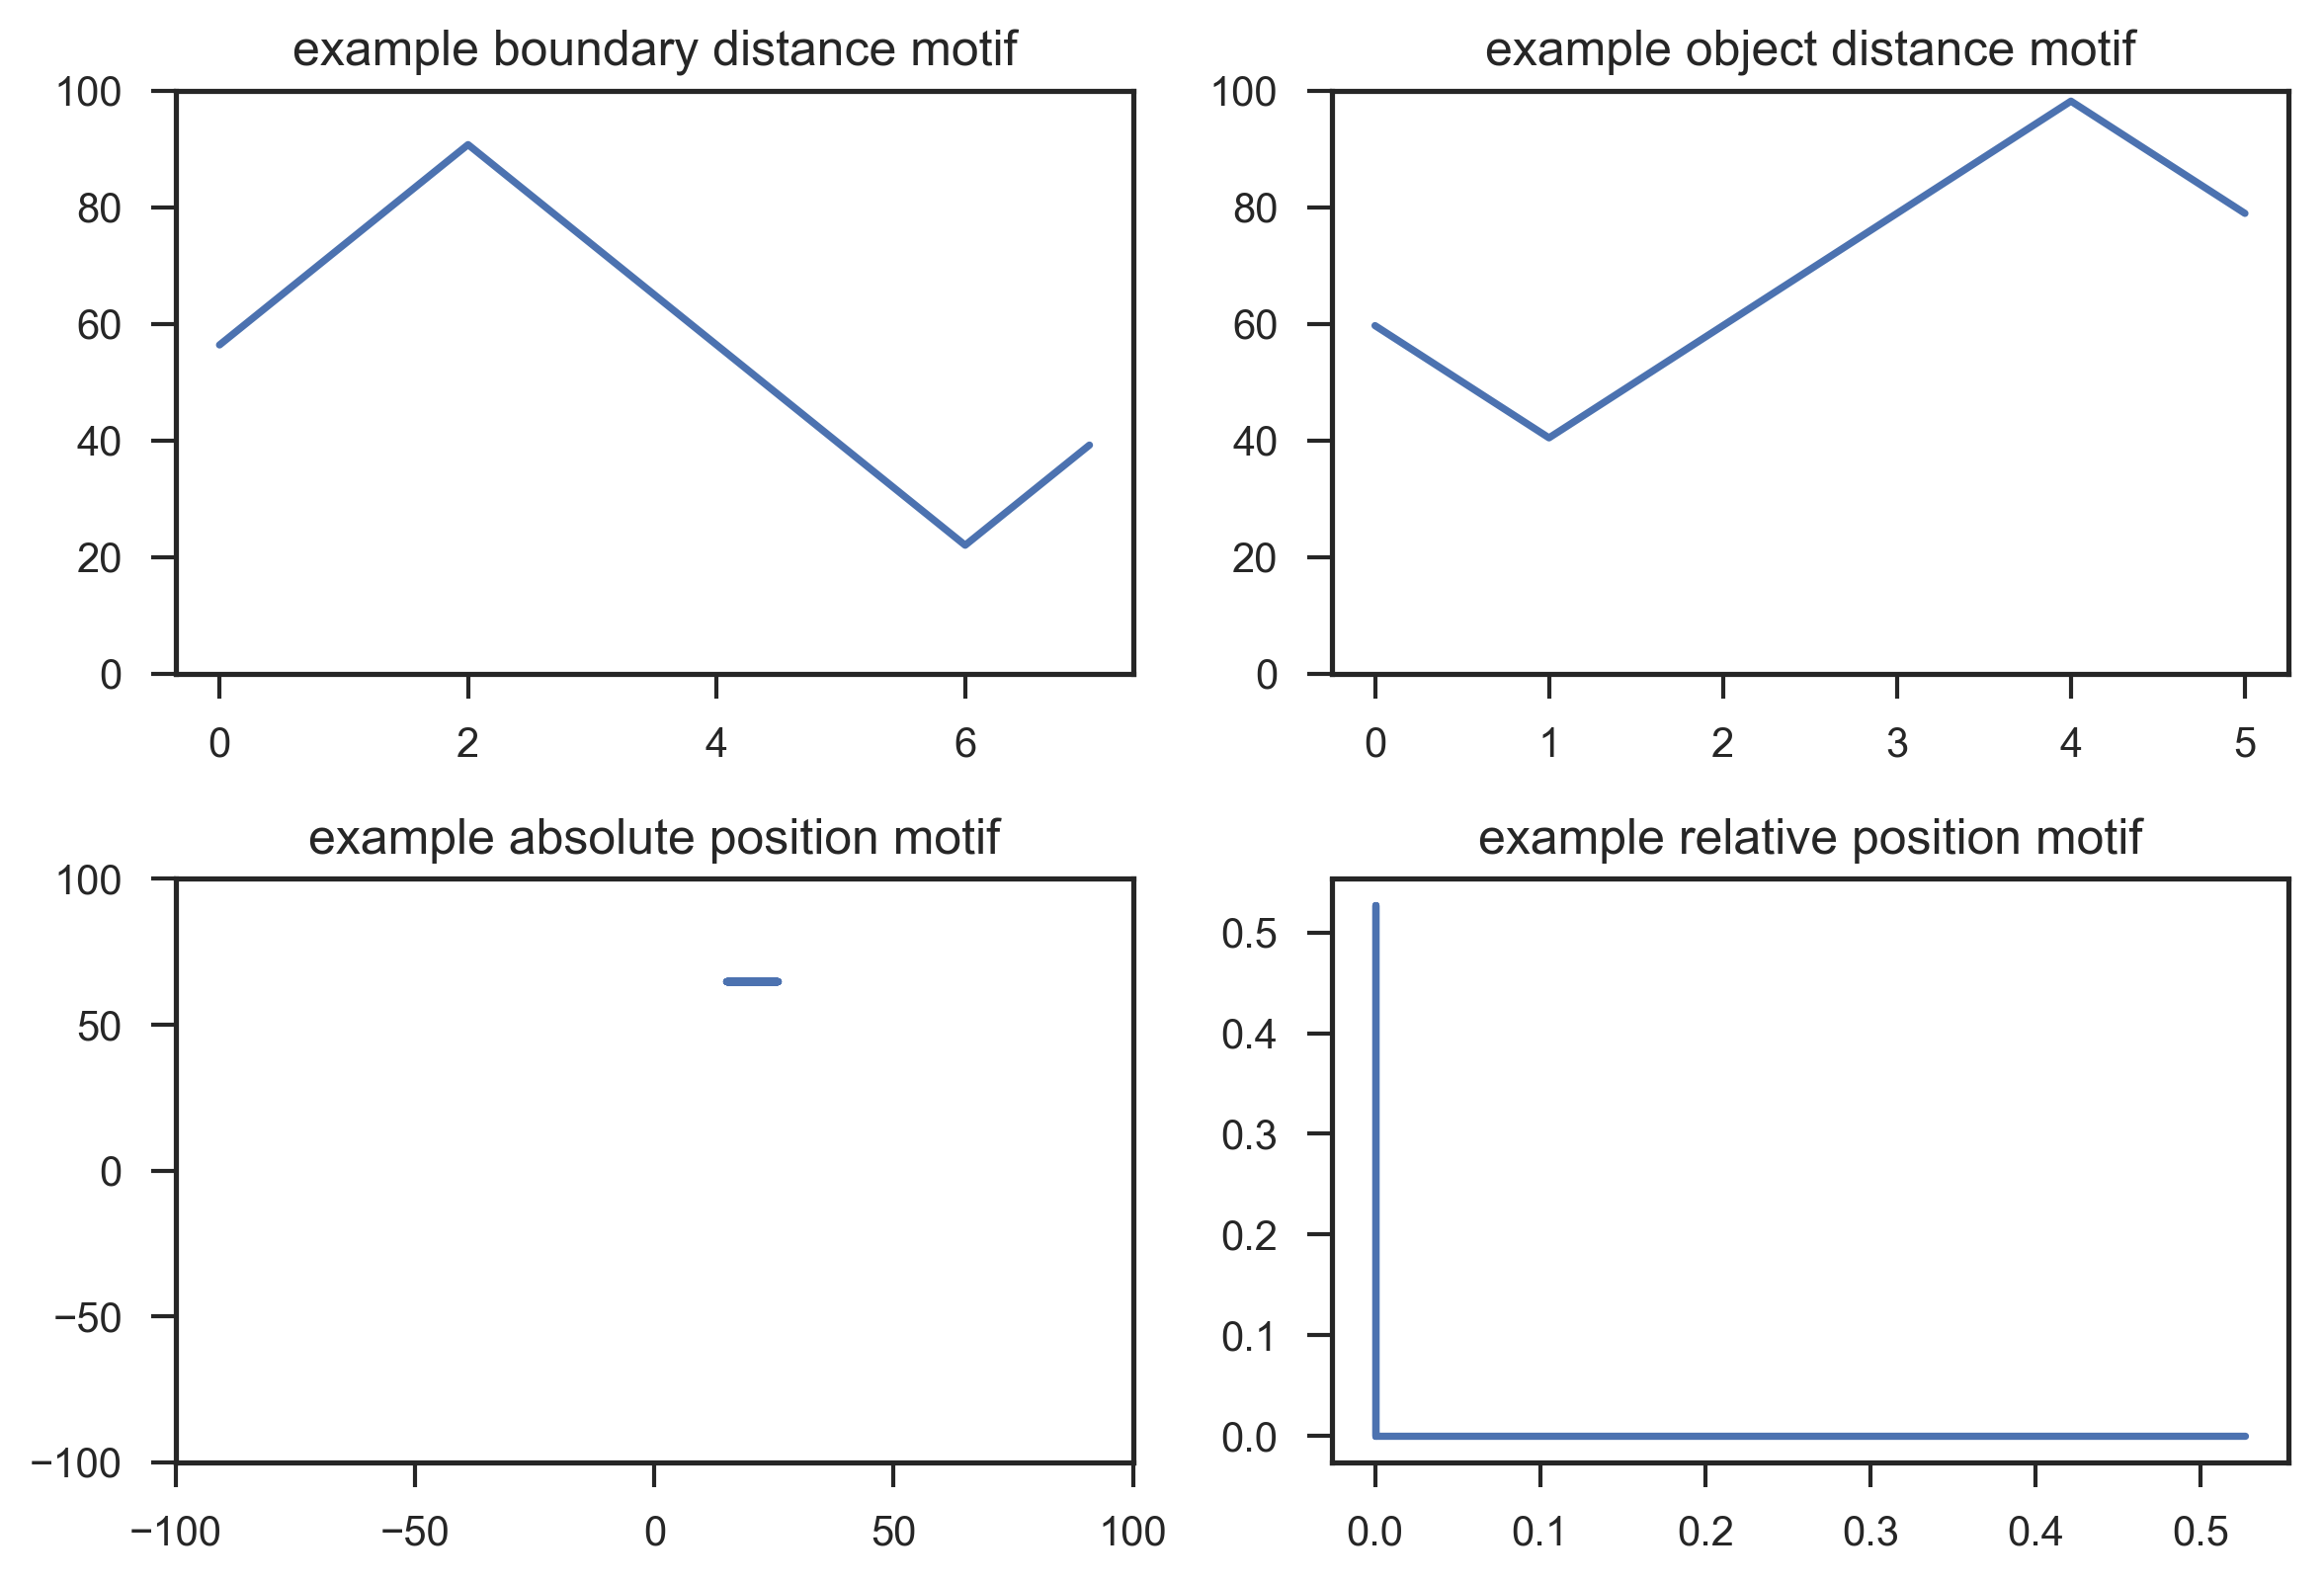

In [194]:
motifs = [((2, 3, 4, 3, 2, 1, 0, 1), 'dist_boundary'),
         ((2, 1, 2, 3, 4, 3), 'dist_object'),
         (((2, 3), (1, 3), (2, 3), (1, 3), (2, 3), (1, 3), (2, 3), (1, 3)), 'pos_abs'),
         (((0, 0), (0, 1), (0, 0), (1, 0)), 'pos_rel')]

fig = plt.figure(dpi=300)
ax = plt.subplot(2,2,1)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,100])
ax.plot(np.array(motifs[0][0])*17.17+22.03)
ax.set_title('example boundary distance motif')

ax = plt.subplot(2,2,2)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,100])
ax.plot(np.array(motifs[1][0])*19.24+21.2)
ax.set_title('example object distance motif')

ax = plt.subplot(2,2,3)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([-100,100])
axes.set_xlim([-100,100])
ax.plot(*(np.array(motifs[2][0])*[ 10.674402,  10.282491]+[  4.32473 ,  34.256293]).T)
ax.set_title('example absolute position motif')

ax = plt.subplot(2,2,4)
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
ax.plot(*(np.array(motifs[3][0]).T*0.5269+1.699e-07))
ax.set_title('example relative position motif')
plt.tight_layout()

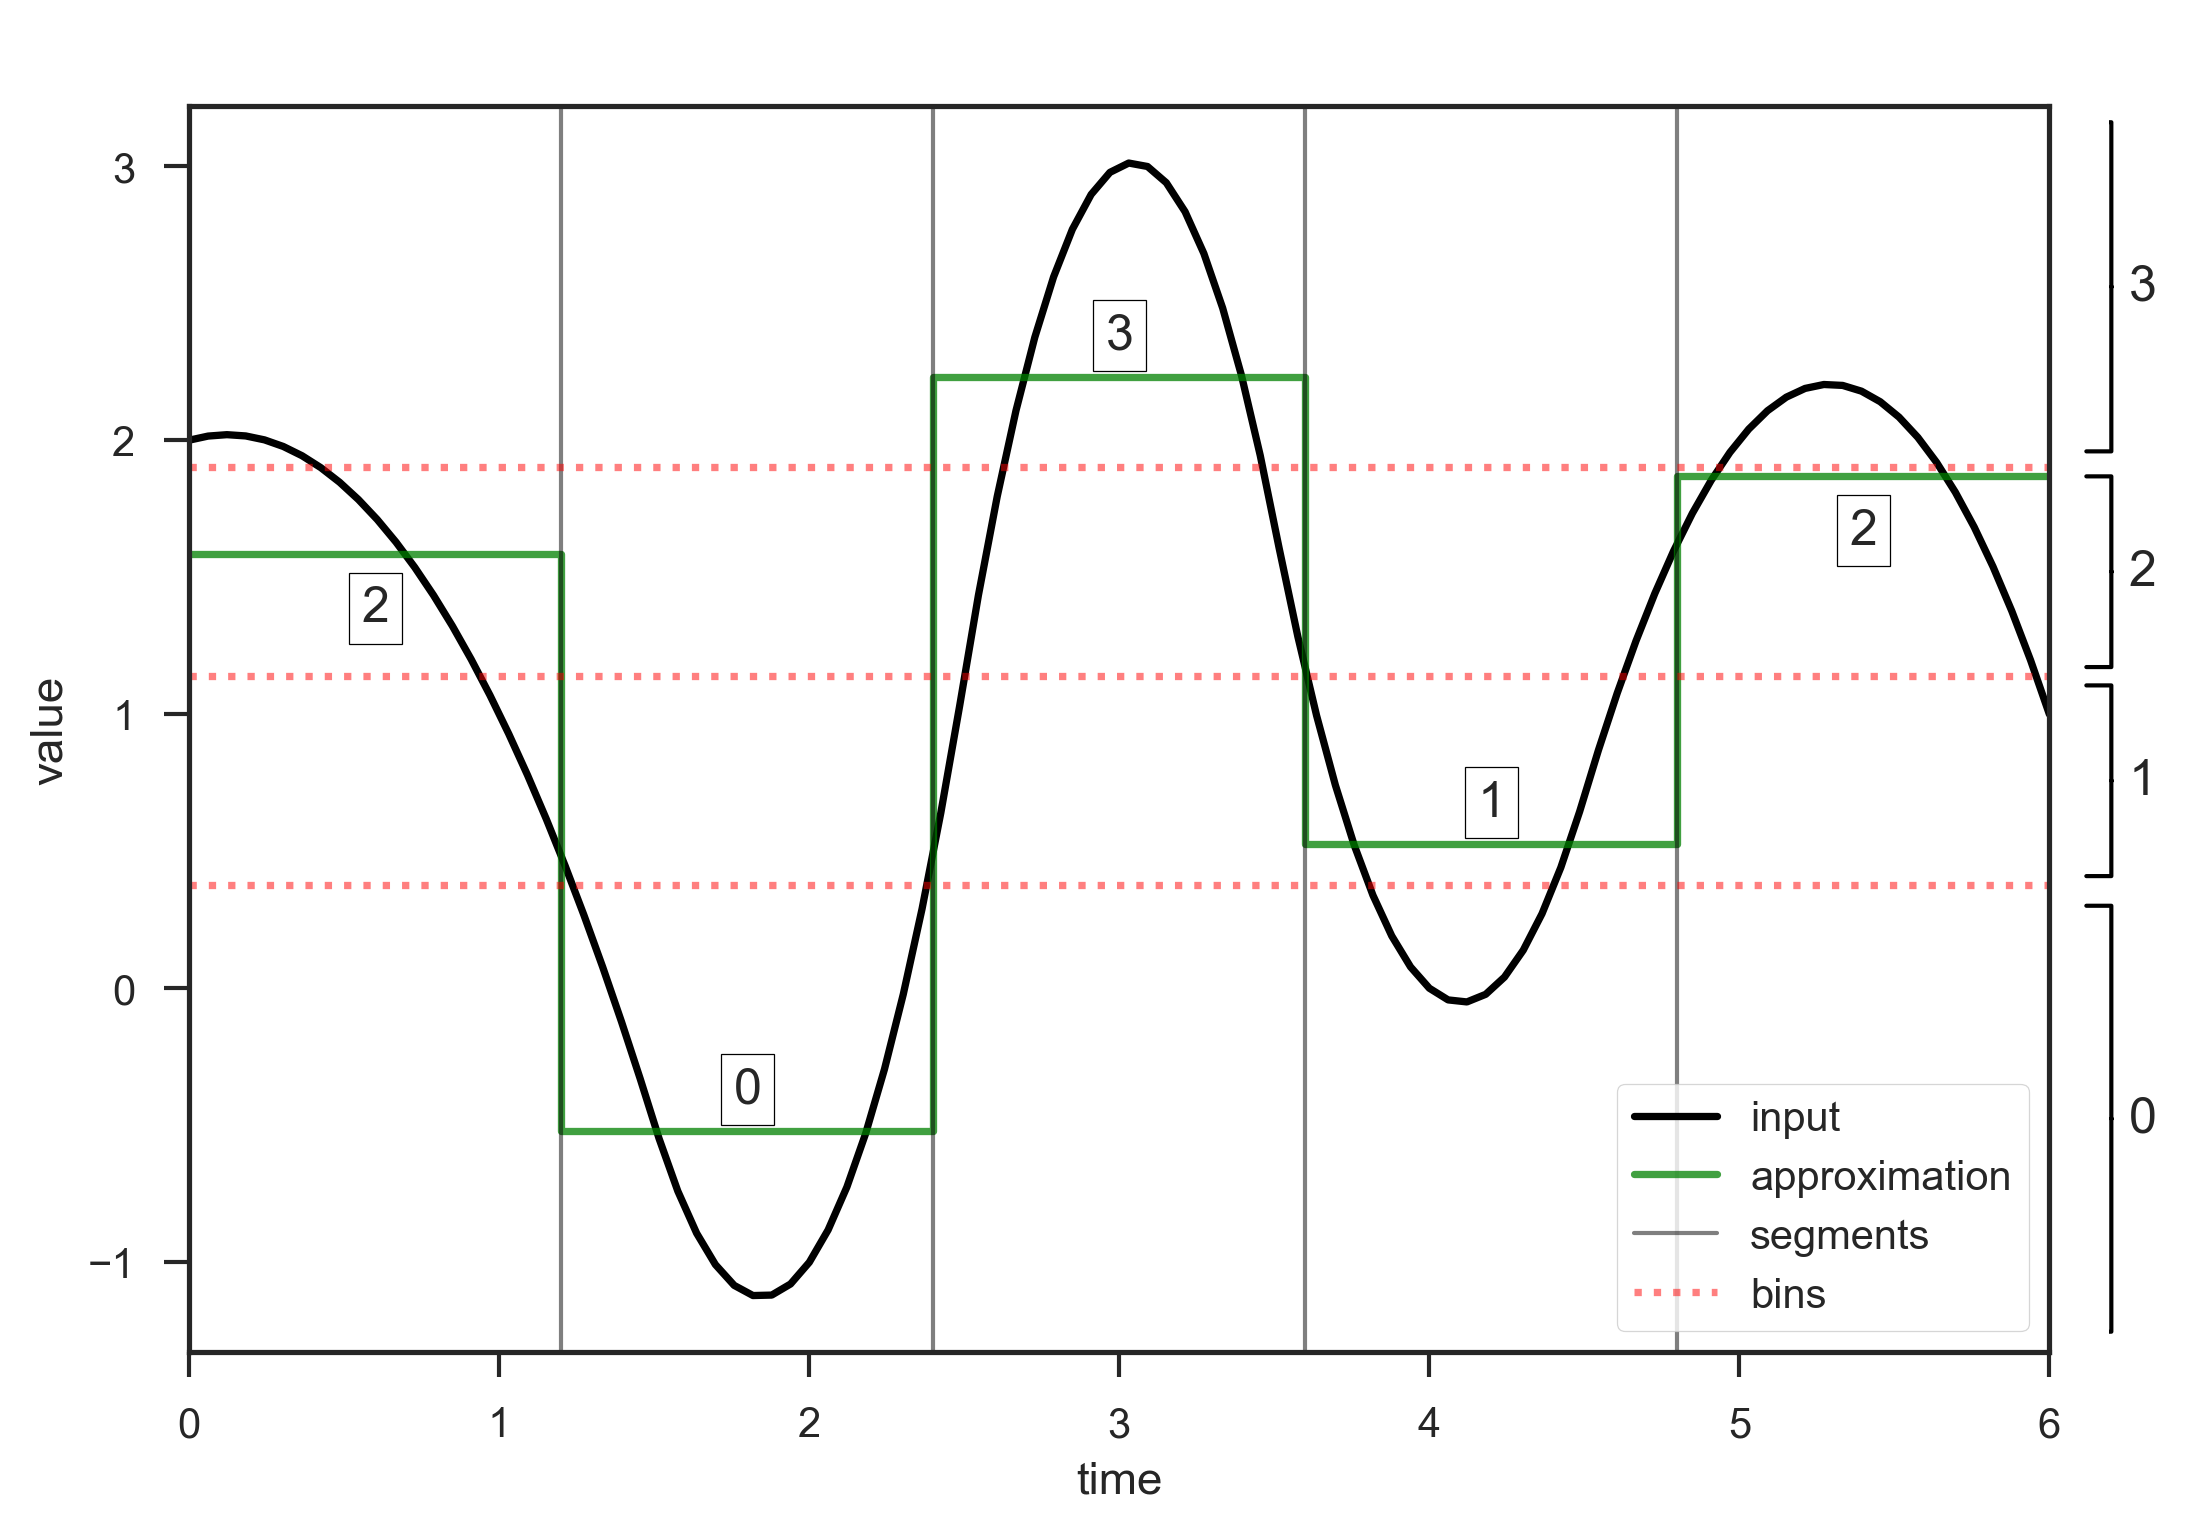

In [520]:
y = [2,1,-1,3,0,2,1]
x = np.linspace(0, len(y)-1, num=len(y), endpoint=True)
f = scipy.interpolate.interp1d(x,y,kind='quadratic')
n = 100
x2 = np.linspace(0, len(y)-1, num=n, endpoint=True)
y2 = f(x2)

fig = plt.figure(dpi=300)
ax = fig.add_subplot(111)

w = 20
vs = sax.split(y2, w).mean(axis=1)
ps = []
d = (len(y)-1)/len(vs)
for i,v in enumerate(vs):
    ps.append((i*d,v))
    ps.append(((i+1)*d,v))
    
ax.plot(x2, y2, '-', color='k', label='input')
ax.plot(*np.array(ps).T, color='g', alpha=0.75, label='approximation')
for i in range(len(vs)):
    ax.axvline(x=i*d, color='k', alpha=0.5, linewidth=1, label='segments' if i == 0 else '')
bins = sax.bins(y2,4)
for i,v in enumerate(bins):
    ax.axhline(y=v, color='r', linestyle=':', alpha=0.5, label='bins' if i == 0 else '')
ax.set_xlim(0,6)
ax.set_xlabel('time')
ax.set_ylabel('value')
ax.legend(loc=4, frameon=True)
offset = [-.2, +.15, +.15, +.15, -.2]
output = [2,0,3,1,2]
for i,v in enumerate(vs):
    ax.text((i+0.5)*d, v+offset[i], output[i], horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='black', pad=3))

bins = np.concatenate(([ax.get_ylim()[0]], bins, [ax.get_ylim()[1]]))
for s,a,b in zip(range(len(bins)),bins[:-1],bins[1:]):
    y = (a+b)/2
    ax.annotate(s, xy=(6.2, y), xytext=(6.3, y), 
        ha='center', va='center',
        arrowprops=dict(arrowstyle=f'-[, widthB={2.5*(b-a)}, lengthB=0.5', lw=1),annotation_clip=False)

# dirty white square hacks to hide bracket ends
ax.add_patch(
    patches.Rectangle(
        (6.1, -1.5),   # (x,y)
        0.0925,          # width
        0.5,          # height
        facecolor='white',
        clip_on=False,
        zorder=10
    )
)
ax.add_patch(
    patches.Rectangle(
        (6.1, 3),   # (x,y)
        0.0925,          # width
        0.5,          # height
        facecolor='white',
        clip_on=False,
        zorder=10
    )
)

In [437]:
import collections

In [438]:
xbins = sax.bins(ds.x.data, 5)
ybins = sax.bins(ds.y.data, 5)

In [449]:
all_secs = collections.Counter()
for rat in ds.rat:
    for session in ds.session:
        d = ds.sel(rat=rat,session=session)
        x = sax.sax(d.x, 15, xbins)
        y = sax.sax(d.y, 15, ybins)
        for t in zip(x,y):
            all_secs[t] += 1

In [450]:
all_secs

Counter({(0, 0): 8541,
         (0, 1): 826,
         (0, 2): 623,
         (0, 3): 20520,
         (0, 4): 23481,
         (1, 0): 782,
         (1, 1): 967,
         (1, 2): 6302,
         (1, 3): 8479,
         (1, 4): 3692,
         (2, 0): 1343,
         (2, 1): 2721,
         (2, 2): 36478,
         (2, 3): 42142,
         (2, 4): 5606,
         (3, 0): 9157,
         (3, 1): 1762,
         (3, 2): 4689,
         (3, 3): 5453,
         (3, 4): 4460,
         (4, 0): 31445,
         (4, 1): 1046,
         (4, 2): 1256,
         (4, 3): 9073,
         (4, 4): 9156})

In [451]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib.cm
import seaborn as sns
sns.set_style('white') 

In [474]:
H = sorted(np.array(list(all_secs.values())),reverse=True)
H

[42142,
 36478,
 31445,
 23481,
 20520,
 9157,
 9156,
 9073,
 8541,
 8479,
 6302,
 5606,
 5453,
 4689,
 4460,
 3692,
 2721,
 1762,
 1343,
 1256,
 1046,
 967,
 826,
 782,
 623]

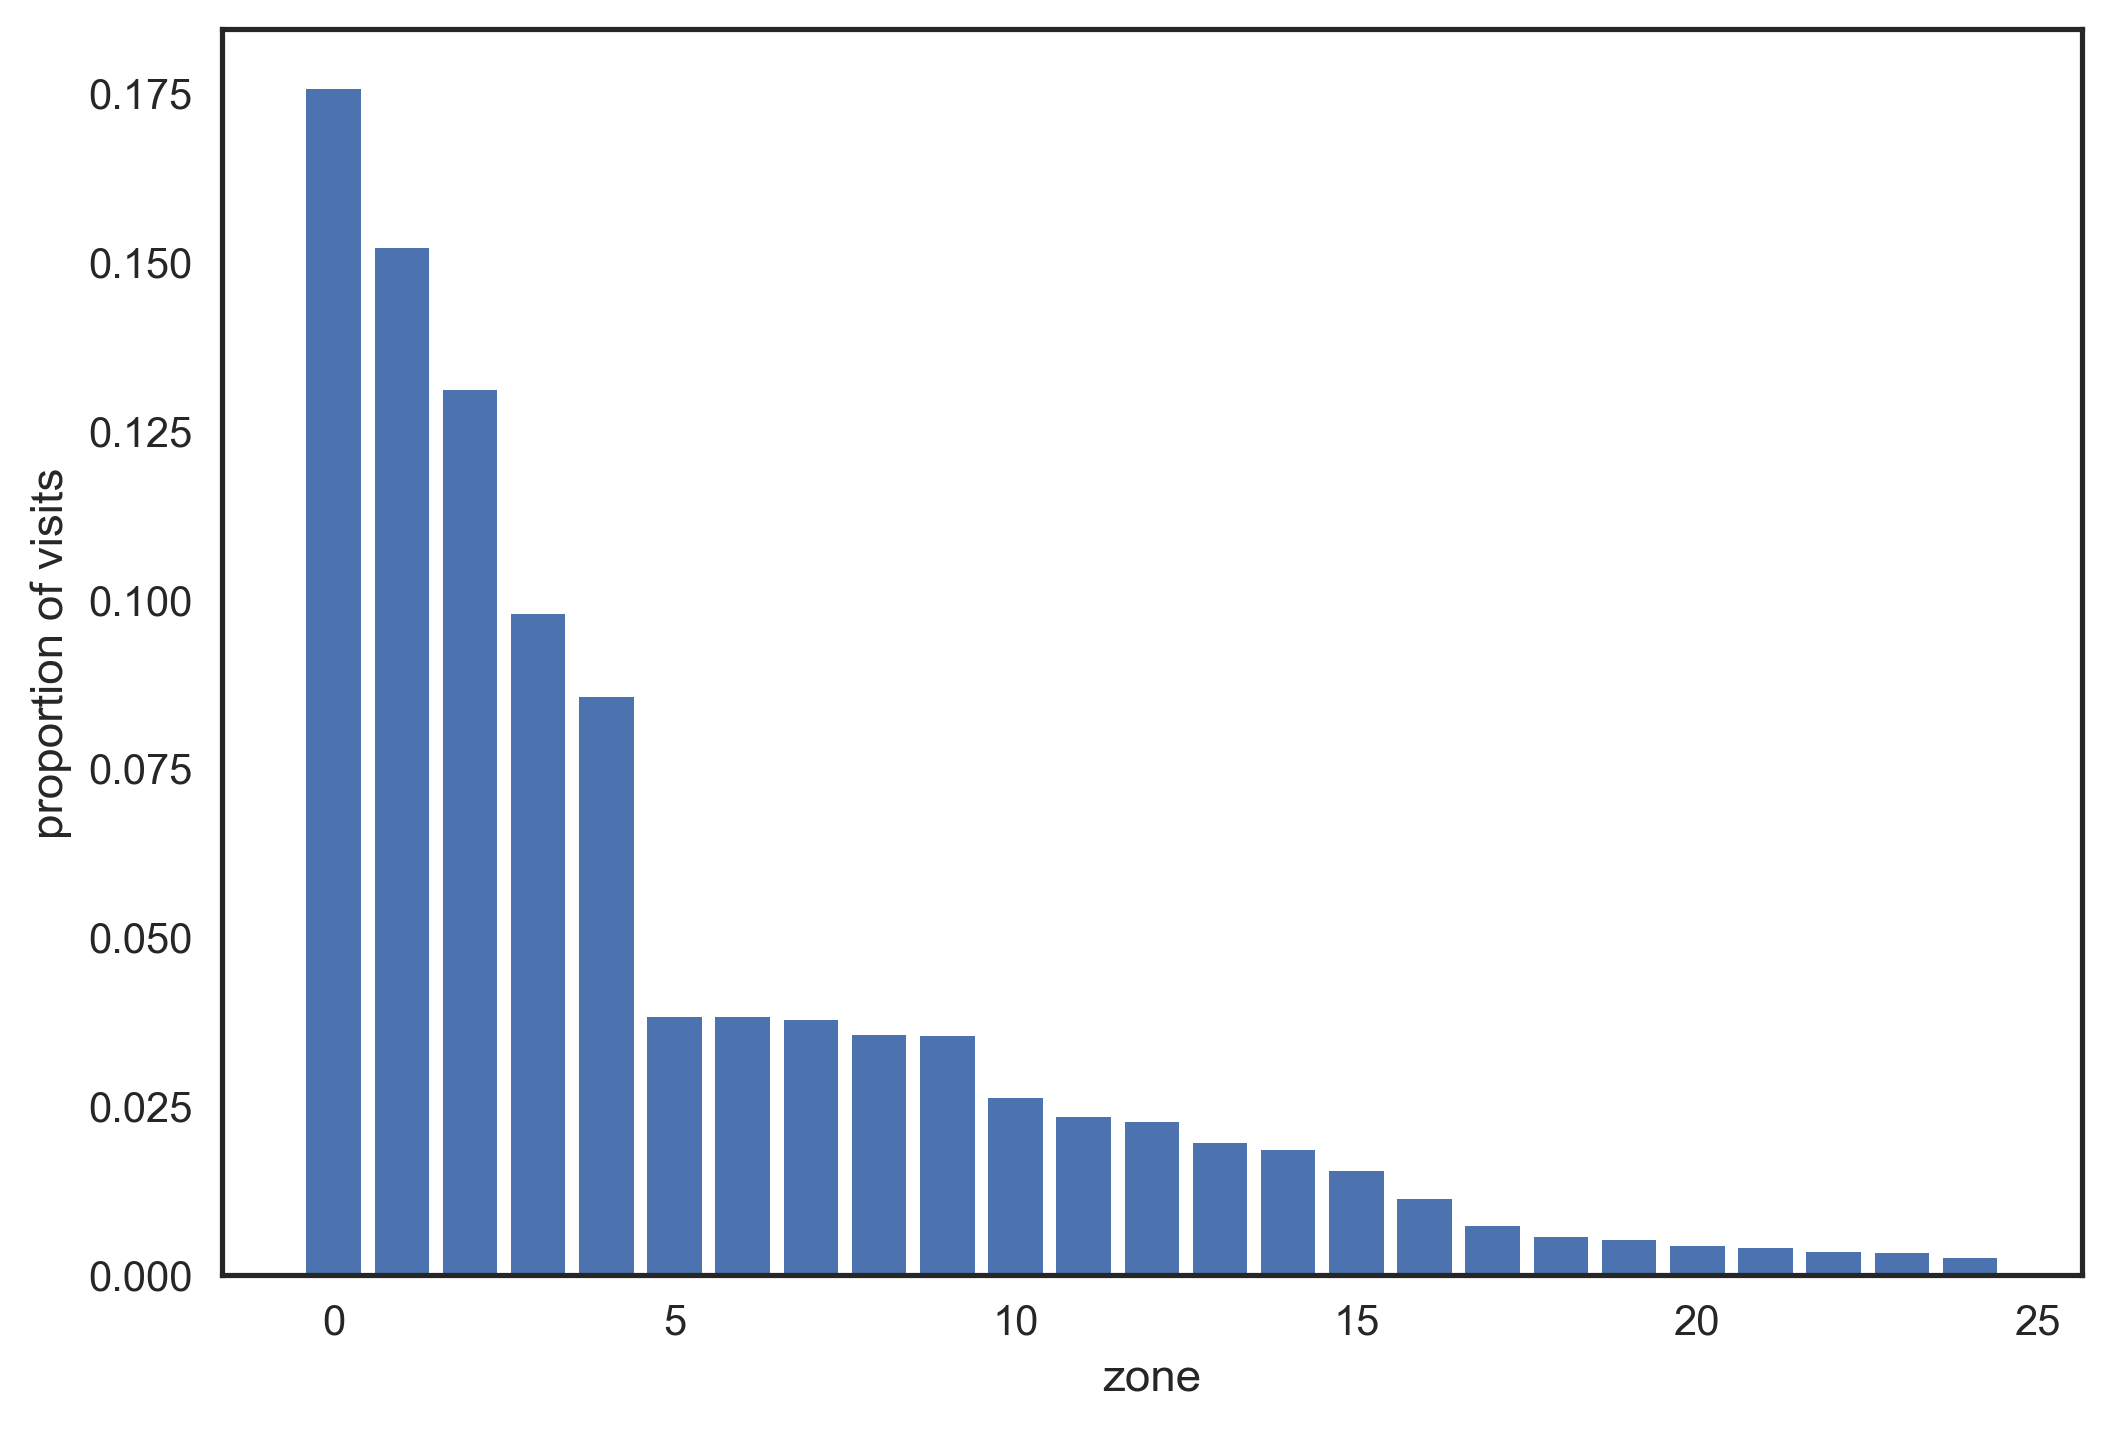

In [475]:
ax = plt.figure(dpi=300).add_subplot(111)
plt.viridis()
ax.bar(range(len(H)),H/sum(H))
ax.set_xlabel('zone')
#ax.set_xticks(range(len(H)),G.keys())
ax.set_ylabel('proportion of visits')

In [476]:
f'{H.var():.1e}'

AttributeError: 'list' object has no attribute 'var'

In [ ]:
import scipy.stats
scipy.stats.entropy(H)

In [ ]:
1258917758.2944/133305620.31999999

[]

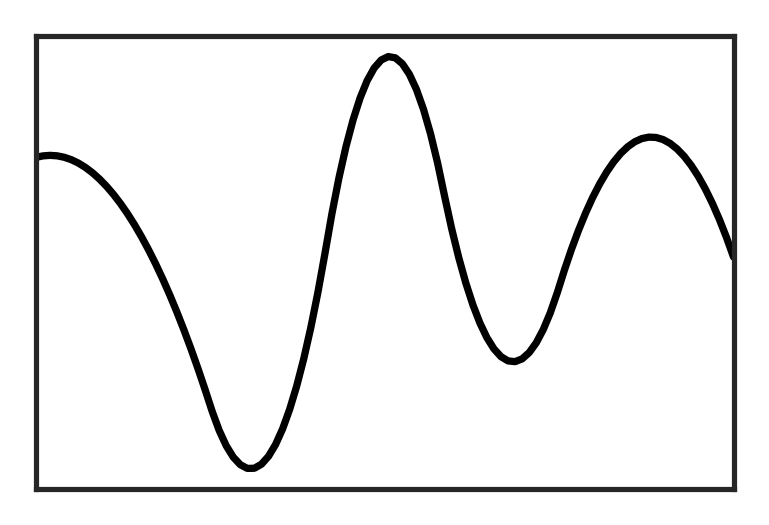

In [533]:
y = [2,1,-1,3,0,2,1]
x = np.linspace(0, len(y)-1, num=len(y), endpoint=True)
f = scipy.interpolate.interp1d(x,y,kind='quadratic')
n = 100
x2 = np.linspace(0, len(y)-1, num=n, endpoint=True)
y2 = f(x2)

fig = plt.figure(dpi=300,figsize=(3,2))
ax = fig.add_subplot(111)

w = 20
vs = sax.split(y2, w).mean(axis=1)
ps = []
d = (len(y)-1)/len(vs)
for i,v in enumerate(vs):
    ps.append((i*d,v))
    ps.append(((i+1)*d,v))
    
ax.plot(x2, y2, '-', color='k', label='input')
#ax.plot(*np.array(ps).T, color='g', alpha=0.75, label='approximation')
# for i in range(len(vs)):
#     ax.axvline(x=i*d, color='k', alpha=0.5, linewidth=1, label='segments' if i == 0 else '')
bins = sax.bins(y2,4)
# for i,v in enumerate(bins):
#     ax.axhline(y=v, color='r', linestyle=':', alpha=0.5, label='bins' if i == 0 else '')
ax.set_xlim(0,6)
# ax.set_xlabel('time')
# ax.set_ylabel('value')
# ax.legend(loc=4, frameon=True)
offset = [-.2, +.15, +.15, +.15, -.2]
output = [2,0,3,1,2]
# for i,v in enumerate(vs):
#     ax.text((i+0.5)*d, v+offset[i], output[i], horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='black', pad=3))

# bins = np.concatenate(([ax.get_ylim()[0]], bins, [ax.get_ylim()[1]]))
# for s,a,b in zip(range(len(bins)),bins[:-1],bins[1:]):
#     y = (a+b)/2
#     ax.annotate(s, xy=(6.2, y), xytext=(6.3, y), 
#         ha='center', va='center',
#         arrowprops=dict(arrowstyle=f'-[, widthB={2.5*(b-a)}, lengthB=0.5', lw=1),annotation_clip=False)

# # dirty white square hacks to hide bracket ends
# ax.add_patch(
#     patches.Rectangle(
#         (6.1, -1.5),   # (x,y)
#         0.0925,          # width
#         0.5,          # height
#         facecolor='white',
#         clip_on=False,
#         zorder=10
#     )
# )
# ax.add_patch(
#     patches.Rectangle(
#         (6.1, 3),   # (x,y)
#         0.0925,          # width
#         0.5,          # height
#         facecolor='white',
#         clip_on=False,
#         zorder=10
#     )
# )
ax.set_xticks([])
ax.set_yticks([])

[]

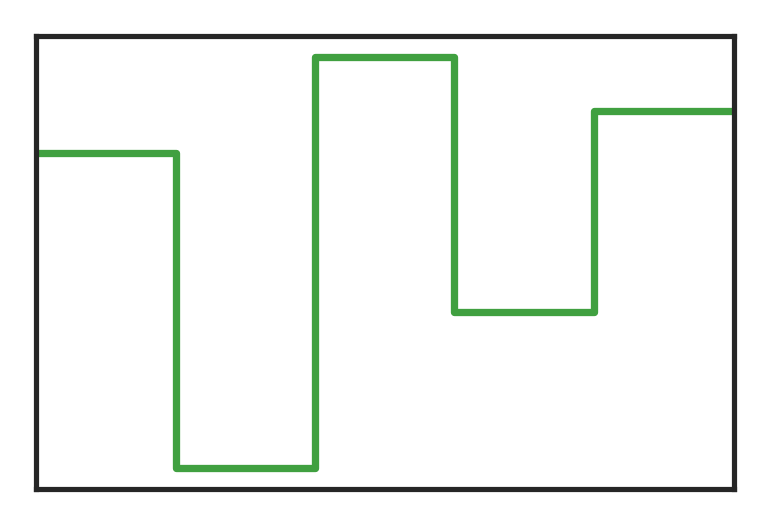

In [535]:
y = [2,1,-1,3,0,2,1]
x = np.linspace(0, len(y)-1, num=len(y), endpoint=True)
f = scipy.interpolate.interp1d(x,y,kind='quadratic')
n = 100
x2 = np.linspace(0, len(y)-1, num=n, endpoint=True)
y2 = f(x2)

fig = plt.figure(dpi=300,figsize=(3,2))
ax = fig.add_subplot(111)

w = 20
vs = sax.split(y2, w).mean(axis=1)
ps = []
d = (len(y)-1)/len(vs)
for i,v in enumerate(vs):
    ps.append((i*d,v))
    ps.append(((i+1)*d,v))
    
# ax.plot(x2, y2, '-', color='k', label='input')
ax.plot(*np.array(ps).T, color='g', alpha=0.75, label='approximation')
# for i in range(len(vs)):
#     ax.axvline(x=i*d, color='k', alpha=0.5, linewidth=1, label='segments' if i == 0 else '')
bins = sax.bins(y2,4)
# for i,v in enumerate(bins):
#     ax.axhline(y=v, color='r', linestyle=':', alpha=0.5, label='bins' if i == 0 else '')
ax.set_xlim(0,6)
# ax.set_xlabel('time')
# ax.set_ylabel('value')
# ax.legend(loc=4, frameon=True)
offset = [-.2, +.15, +.15, +.15, -.2]
output = [2,0,3,1,2]
# for i,v in enumerate(vs):
#     ax.text((i+0.5)*d, v+offset[i], output[i], horizontalalignment='center', verticalalignment='center', bbox=dict(facecolor='white', edgecolor='black', pad=3))

# bins = np.concatenate(([ax.get_ylim()[0]], bins, [ax.get_ylim()[1]]))
# for s,a,b in zip(range(len(bins)),bins[:-1],bins[1:]):
#     y = (a+b)/2
#     ax.annotate(s, xy=(6.2, y), xytext=(6.3, y), 
#         ha='center', va='center',
#         arrowprops=dict(arrowstyle=f'-[, widthB={2.5*(b-a)}, lengthB=0.5', lw=1),annotation_clip=False)

# # dirty white square hacks to hide bracket ends
# ax.add_patch(
#     patches.Rectangle(
#         (6.1, -1.5),   # (x,y)
#         0.0925,          # width
#         0.5,          # height
#         facecolor='white',
#         clip_on=False,
#         zorder=10
#     )
# )
# ax.add_patch(
#     patches.Rectangle(
#         (6.1, 3),   # (x,y)
#         0.0925,          # width
#         0.5,          # height
#         facecolor='white',
#         clip_on=False,
#         zorder=10
#     )
# )
ax.set_xticks([])
ax.set_yticks([])